<a href="https://colab.research.google.com/github/g-r-a-e-m-e/essential-math-for-data-science/blob/main/chapter_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 06
## Logistic Regression and Classification

### Performing a Logistic Regression

#### Logistic Function

$y = {\displaystyle \frac{1.0}{1.0 + e^{-(\beta_0 + \beta_1 x)}}}$

In [1]:
# Example 6-1. The logistic function
import math

# Define function to predict probability
def predict_probability(x, b0, b1):
  p = 1.0 / (1.0 + math.exp(-(b0 + b1 * x)))
  return p

1.0/(1.0 + 16.8272567955368*exp(-0.62*x))


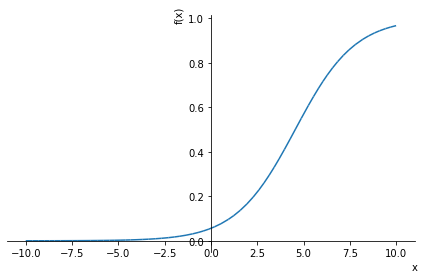

In [3]:
# Example 6-2. Using SymPy to plot a logistic function
from sympy import *
b0, b1, x = symbols('b0 b1 x')

p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))

p = p.subs(b0, -2.823)
p = p.subs(b1, 0.620)
print(p)

plot(p)

Alternative logistic function

$p = {\displaystyle \frac{e^{\beta_0 + \beta_1 x}}{1.0 + e^{\beta_0 + \beta_1 x}}}$

Extending logistic function to more variables

$p = {\displaystyle \frac{1.0}{e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n)}}}$

#### Fitting the Logistic Curve
##### Using SciPy

In [ ]:
# Example 6-3. Using a plain logistic regression in SciPy
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter = ',')

# Extract input variables
X = df.values[:, :-1]

# Extract output column
y = df.values[:, -1]

# Perform logistic regression
model = LogisticRegression(penalty = 'none')

# Fit model
model.fit(X, y)

# Print beta_1
print(model.coef_.flatten())

# Print beta_0
print(model.intercept_.flatten())